# Part2. Model design 3

Data Augmentation - SMOTE 
(Synthetic Minority Oversampling Technique) to overcome the data imbalance

In [1]:
from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.metrics import SpecificityAtSensitivity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
#load the original data
df1=pd.read_csv("../Data/kag_risk_factors_cervical_cancer.csv")

#load the processed datasets:
X_train=pd.read_csv("../Data/X_train_preprocessed.csv")
X_test=pd.read_csv("../Data/X_test_preprocessed.csv")
X_validate=pd.read_csv("../Data/X_validate_preprocessed.csv")
y_train=pd.read_csv("../Data/y_train_preprocessed.csv")
y_test=pd.read_csv("../Data/y_test_preprocessed.csv")
y_validate=pd.read_csv("../Data/y_validate_preprocessed.csv")

In [3]:
#convert df to np:
y_train_np=y_train.to_numpy()
X_train_np=X_train.to_numpy()

In [4]:
#using SMOTE create a balanced train dataset:
x_train_s, y_train_s = SMOTE(random_state=33).fit_resample(X_train_np, y_train_np.ravel())
print(sorted(Counter(y_train_s).items()))

# now I  have a training dataset perfectly balanced:

[(0, 615), (1, 615)]


In [5]:
print(x_train_s.shape, y_train_s.shape)


(1230, 31) (1230,)


Apply Decission Tree Classifier and Random Forest Classifier to SMOTE data
A grid search could be done to optimize parameters. 

In [8]:
l_final = [] #--> New list for storing metrics of base models

def models_dt(x,y,x_test,y_test):
    mod = {}
    model = DecisionTreeClassifier().fit(x,y)
    ypred = model.predict(x_test)
    mod['Model'] = 'Decision Tree After Sampling'
    mod['Train_Score'] = model.score(x_train_s,y_train_s)
    mod['Test_accuracy'] = metrics.accuracy_score(y_test,ypred)
    mod['f1score'] = metrics.f1_score(y_test,ypred)
    mod['recall'] = metrics.recall_score(y_test, ypred)
    mod['precision'] = metrics.precision_score(y_test, ypred)
    model.predict_proba(x_test)
    mod['roc_auc'] = metrics.roc_auc_score(y_test,ypred)
    return mod

l_final.append(models_dt(x_train_s,y_train_s,X_test,y_test))

def models_rf(x,y, x_test, y_test):
    mod = {}
    model = RandomForestClassifier().fit(x,y)
    ypred = model.predict(x_test)
    mod['Model'] = 'Random Forest After Sampling'
    mod['Train_Score'] = model.score(x_train_s,y_train_s)
    mod['Test_accuracy'] = metrics.accuracy_score(y_test,ypred)
    mod['f1score'] = metrics.f1_score(y_test,ypred)
    mod['recall'] = metrics.recall_score(y_test, ypred)
    mod['precision'] = metrics.precision_score(y_test, ypred)
    model.predict_proba(x_test)
    mod['roc_auc'] = metrics.roc_auc_score(y_test,ypred)
    return mod

l_final.append(models_rf(x_train_s,y_train_s, X_test, y_test))


In [9]:
final_model = pd.DataFrame(l_final)
final_model

,Model,Train_Score,Test_accuracy,f1score,recall,precision,roc_auc
0,Decision Tree After Sampling,1.0,0.948276,0.625000,0.555556,0.714286,0.768432
1,Random Forest After Sampling,1.0,0.956897,0.736842,0.777778,0.700000,0.874870


Recall is 0.66 with Random Forest

### Use the neural network model from "cervix_project_2_Model_design_1"

In [10]:
model = Sequential() 

#Input layer
model.add(Dense(units=500, 
            input_dim=31, # i have 31 features
            kernel_initializer='uniform', # all features have the same weight
            activation='relu'
               ))
model.add(Dropout(0.5))  #randomly sets 0.5 units to 0. To prevent overfitting
#Hidden layer 1
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 2
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Hidden layer 3
model.add(Dense(units=500,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(units=1, #only one unit needed, it its either 1 or not 1
                kernel_initializer='uniform', 
                activation='sigmoid'))

#model(output_bias=initial_bias)

print(model.summary()) #for showing the structure and parameters

# Defining how to measure performance
model.compile(loss='binary_crossentropy',   
              optimizer='adam',
               metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])


# Train the model
# Verbose=2, showing loss and accuracy change timely
#remove batch_size, the dataset is small. -> it increases recall.
train_history = model.fit(x=x_train_s, y=y_train_s,  
                          validation_split=0.2, epochs=50, verbose=2) 



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               16000     
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               2

Epoch 38/50
31/31 - 0s - loss: 0.0344 - precision: 0.9865 - recall: 0.9919 - accuracy: 0.9919 - val_loss: 0.0101 - val_precision: 1.0000 - val_recall: 0.9959 - val_accuracy: 0.9959
Epoch 39/50
31/31 - 0s - loss: 0.0254 - precision: 0.9840 - recall: 0.9973 - accuracy: 0.9929 - val_loss: 0.0157 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 40/50
31/31 - 0s - loss: 0.0215 - precision: 0.9865 - recall: 0.9919 - accuracy: 0.9919 - val_loss: 0.0464 - val_precision: 1.0000 - val_recall: 0.9919 - val_accuracy: 0.9919
Epoch 41/50
31/31 - 0s - loss: 0.0194 - precision: 0.9839 - recall: 0.9946 - accuracy: 0.9919 - val_loss: 0.0048 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 42/50
31/31 - 0s - loss: 0.0146 - precision: 0.9919 - recall: 0.9973 - accuracy: 0.9959 - val_loss: 0.0044 - val_precision: 1.0000 - val_recall: 1.0000 - val_accuracy: 1.0000
Epoch 43/50
31/31 - 0s - loss: 0.0257 - precision: 0.9839 - recall: 0.9946 - accuracy: 0.9919 -

In [11]:
scores = model.evaluate(X_test, y_test)
print('\n')


4/4 [==============================] - 0s 3ms/step - loss: 0.9632 - precision: 0.7500 - recall: 0.6667 - accuracy: 0.9569




Recall is worse than with Random forest classifier (0.55 vs 0.66)

We could also use a fore strict feature selection to improve the recall, but porbably because of the small sample size and the imbalanced dataset these numbers cannot be improved much more

In [12]:
y_pred_test=model.predict_classes(X_test, verbose=1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
4/4 [==============================] - 0s 9ms/step


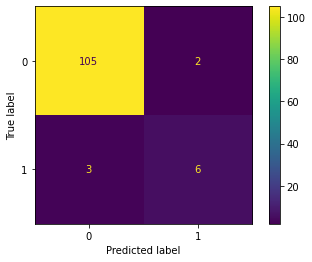

In [13]:
cm = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(cm).plot()

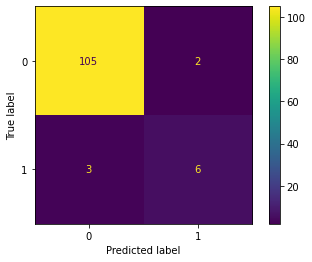

In [14]:
#same conf. matrix.
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)
p=0.8

cm = confusion_matrix(y_test, test_predictions_baseline > p)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [15]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

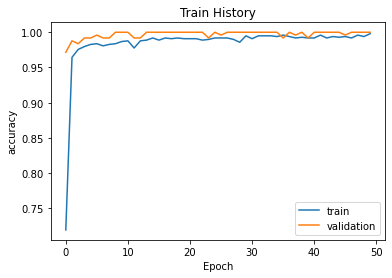

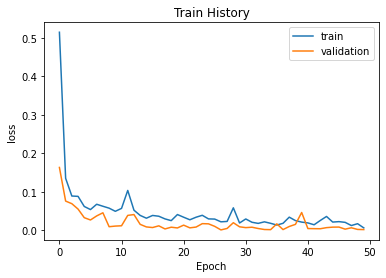

In [16]:
#visualize the loss and accuracy after each epoch
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

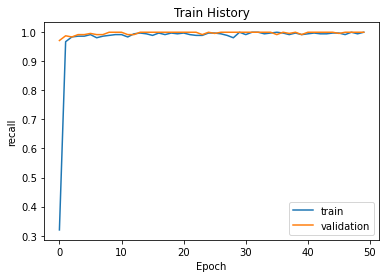

In [18]:
#visualize recall, what we really want to increase, after each epoch
show_train_history(train_history,'recall','val_recall')
